# Training with all representations

In [1]:
!python -m pip list

Package                Version  
---------------------- ---------
absl-py                0.12.0   
anyio                  2.2.0    
argon2-cffi            20.1.0   
astunparse             1.6.3    
async-generator        1.10     
attrs                  20.3.0   
Babel                  2.9.0    
backcall               0.2.0    
bleach                 3.3.0    
cachetools             4.2.1    
certifi                2020.12.5
cffi                   1.14.5   
chardet                4.0.0    
cycler                 0.10.0   
dask                   2021.3.0 
decorator              4.4.2    
defusedxml             0.7.1    
entrypoints            0.3      
flatbuffers            1.12     
gast                   0.3.3    
google-auth            1.27.1   
google-auth-oauthlib   0.4.3    
google-pasta           0.2.0    
grpcio                 1.32.0   
h5py                   2.10.0   
idna                   2.10     
ipykernel              5.5.0    
ipython                7.21.0   
ipython-ge

In [2]:
!nvidia-smi

Mon Mar 22 01:41:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8    12W / 151W |     72MiB /  8118MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm
import seaborn as sn
import numpy as np
import time

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.datasets import delaunay
from spektral.layers import *
from spektral.utils.convolution import localpooling_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tqdm.contrib.concurrent import process_map, thread_map

from utils import yaml_load, get_section

%matplotlib inline

# General functions

Here we are going to define some general functions, for different purposes, used along the whole notebook.

In [4]:
def create_model(n_nodes, n_features, n_classes, learning_rate):
    N = n_nodes
    F = n_features
    
    # Model definition
    conv   = GraphConv(45,activation='relu',use_bias=False)
    mincut = MinCutPool(N // 2)
    conv2  = GraphConv(55,activation='relu',use_bias=False)
    pool   = GlobalAttnSumPool()

    # First Graph Layers
    X1_in = Input(shape=(N, F))
    A1_in = Input((N, N))
    gc2_1 = conv([X1_in, A1_in])
    gc2_1, A1 = mincut([gc2_1,A1_in])
    gc2_1 = conv2([gc2_1, A1])
    pool_1 =  pool(gc2_1)
    d1 = Dense(200,activation='relu')(pool_1)

    # Second Graph Layers
    X2_in = Input(shape=(N, F))
    A2_in = Input((N, N))
    gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
    gc2_2, A2 = mincut([gc2_2,A2_in])
    gc2_2 = conv2([gc2_2, A2])
    pool_2 = pool(gc2_2)
    d2 = Dense(200,activation='relu')(pool_2)

    # Dense final layers
    merged = Concatenate()([d1, d2])

    merged1 = Dense(800,activation='relu')(merged)
    merged2 = Dense(32,activation='relu')(merged1)

    classe = Dense(n_classes, name="class",activation="softmax")(merged2)
    speedup = Dense(1, name="speddup")(merged2)

    # Build model
    model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe,speedup])
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'],loss_weights=[1, 0.00005], weighted_metrics=['acc'])
    return model

In [9]:
# Load and prepare inputs, in the .npz file, to train by the model
def get_inputs(input_data_file: str, test_size: float) -> tuple:
    """Load and prepare samples to be used by the model. Also, splits the samples in train and test sets. 
    
    Parameters:
        input_data_file (str): Numpy file containing the graphs, features and speedups from all samples
        test_size (float): Number of samples to used as test
        
    Returns:
        A tuple with 6 elements (in order), being:
        * The graphs used to train
        * The graphs used to test
        * The graph features used to train
        * The graph features used to test
        * The speedup used to train
        * The speedup used to test
    """
    # Read all data
    with np.load(input_data_file, allow_pickle=True) as all_data:
        graphs = all_data['graphs']        # Graphs matrices
        features = all_data['features']    # Features matrices
        speedups = all_data['speedups']    # Speedup matrices (targets)

    print(f'Data loaded from {input_data_file}')
    
    # Generate classed based on speedup [0-4]
    y_c = np.zeros(shape=(speedups.shape[0],5))

    for i in range(0, speedups.shape[0]):
        if speedups[i] <= 0.996:
            y_c[i,0]=1
        elif speedups[i] > 0.996 and speedups[i] < 1.0:
            y_c[i,1]=1
        elif (speedups[i] >= 1.0 and speedups[i] < 1.15):
            y_c[i,2]=1
        elif (speedups[i] > 1.15):
            y_c[i,3]= 1
        y_c[i,4] =speedups[i]
    speedups = y_c
    
    
    print(f"""Speedup classes generated from data:
        Class A: {int(sum(speedups[:, 0]))} elements
        Class B: {int(sum(speedups[:, 1]))} elements
        Class C: {int(sum(speedups[:, 2]))} elements
        Class D: {int(sum(speedups[:, 3]))} elements
    """)
    
    # Remove 0 columns in nodes features
    #idx = np.argwhere(np.all(X[..., :] == 0, axis=(0,1,2)))
    #X = np.delete(X, idx, axis=3)

    print(f"""Datas:
        Graphs shape:   {graphs.shape}
        Features shape: {features.shape}
        Speedups shape: {speedups.shape} 
    """)

    # Preprocess all graphs with Spektral package
    graphs[:,0,:,:] = GraphConv.preprocess(graphs[:,0,:,:]).astype('f4')
    graphs[:,1,:,:] = GraphConv.preprocess(graphs[:,1,:,:]).astype('f4')
    print("Graphs preprocessed!")
    
    # Split train and test sets
    graphs_train, graphs_test, features_train, features_test, speedups_train, speedups_test = train_test_split(graphs, features, speedups, shuffle=True, test_size=test_size)
    print("Dataset splitted!")
    
    return graphs_train, graphs_test, features_train, features_test, speedups_train, speedups_test

In [6]:
# Function used to store information about training
def dump_info(data_dir: str, config_dict: dict):
    """Create directories and store informations about training
    
    Parameters:
        data_dir (str): Directory to store information about training (model, weights, results, etc.)
        config_dict (dict): Dictionary with information about training
    
    Returns:
        None
    """
    # Create the directories to store information about training
    os.makedirs(data_dir, exist_ok=True)
    output_file = os.path.join(data_dir, 'info.yaml')

    with open(output_file, 'wt') as f:
        yaml.dump(config_dict, f)
    
    print(f'Information saved to {output_file}')

In [7]:
# Save model topology and weights
def save_model(data_dir: str, model: Model):
    """Save model topology and weights to files (model.yaml and weights.h5, respectively) in data_dir
    
    Parameters:
        data_dir (str): Directory to store model topology and weights
        model: Model to save
    
    Returns:
        None
    """
    # Saving model and weights
    output_model_file = os.path.join(data_dir, 'model.yaml')
    with open(output_model_file, 'wt') as f:
        yaml.dump(model.to_yaml(), f)
    print(f'Model saved to {output_model_file}')

    output_weights_file = os.path.join(data_dir, 'weights.h5')
    model.save_weights(output_weights_file)
    print(f"Weights saved to file {output_weights_file}")

# Training with CFG graphs. Shape 150x150

Information saved to ./model_data/GNN_cfg_150x150_1616333129.9531538/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cfgs_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150)]   0                                            
_________________________________________________________________

2684

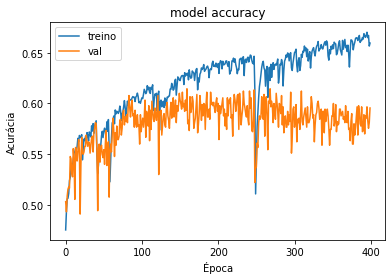

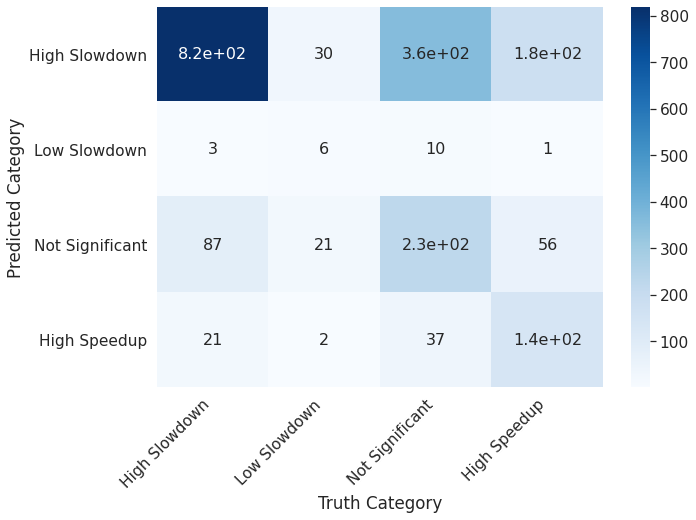

In [8]:
# Configuration information about training
config = {
    'input_data': './data/cfgs_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cfg',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

# Training with CFG graphs. Shape 300x300

Information saved to ./model_data/GNN_cfg_300x300_1616334698.2824042/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cfgs_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 67)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300, 300)]   0                                            
_______________________________________________________________

19211

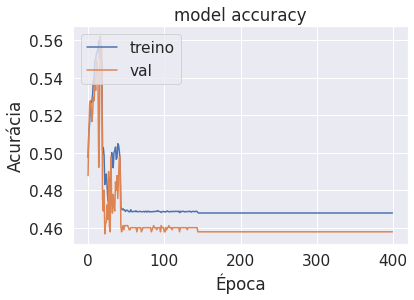

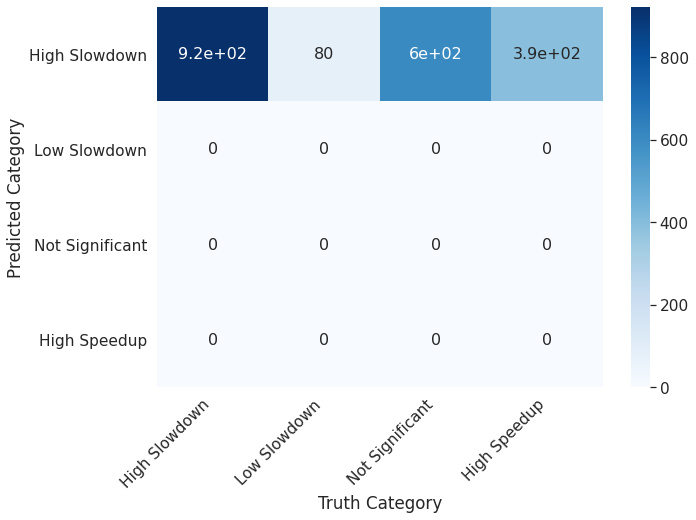

In [9]:
# Configuration information about training
config = {
    'input_data': './data/cfgs_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cfg',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

# Training with CDFG graphs. Shape 150x150

## Graph with control, data and call edges

In [ ]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-data-call_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-data-call',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

Information saved to ./model_data/GNN_cdfg-control-data-call_150x150_1616388214.72361/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-data-call_20000samples_150x150.npz
Speedup classes generated from data:
        Class A: 7839 elements
        Class B: 2149 elements
        Class C: 6704 elements
        Class D: 3308 elements
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 200)]   0                                            
________________________________________________________________________________________________

## Graph with control and data edges

Information saved to ./model_data/GNN_cdfg-control-data_150x150_1616340695.1232014/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-data_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________

18701

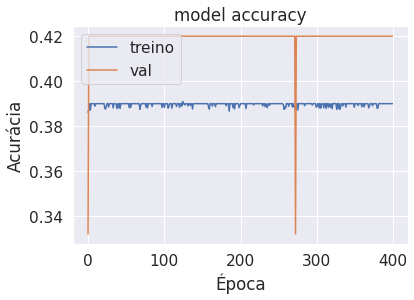

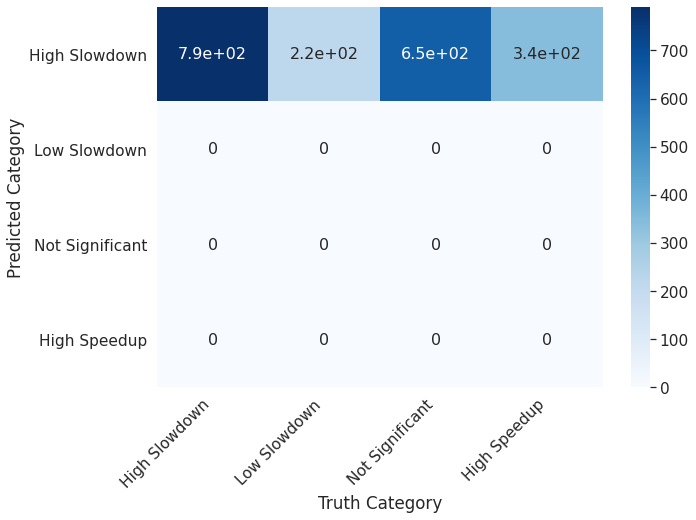

In [11]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-data_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-data',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with control and call edges

Information saved to ./model_data/GNN_cdfg-control-call_150x150_1616342523.4218557/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-call_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________

18701

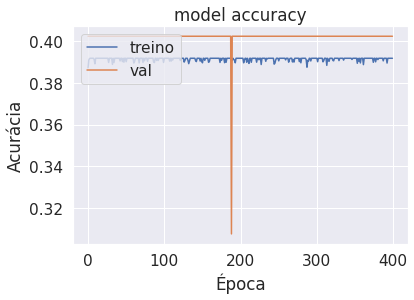

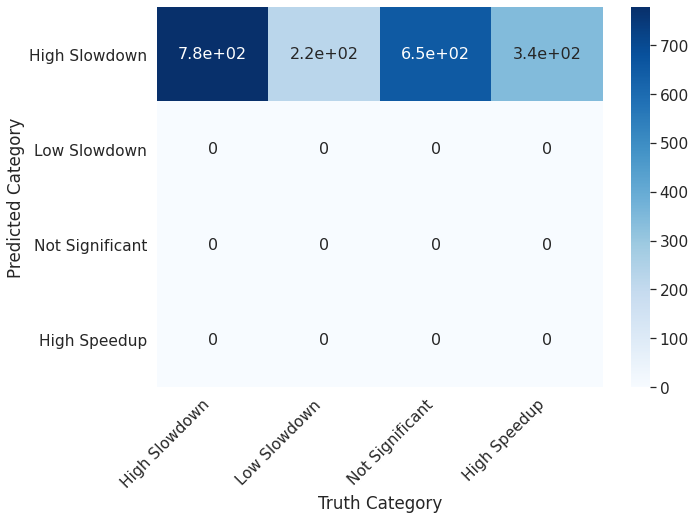

In [12]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-call_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-call',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graphs with data and call edges

Information saved to ./model_data/GNN_cdfg-data-call_150x150_1616344330.504246/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_data-call_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 150, 150)]   0                                            
_________________________________________

18701

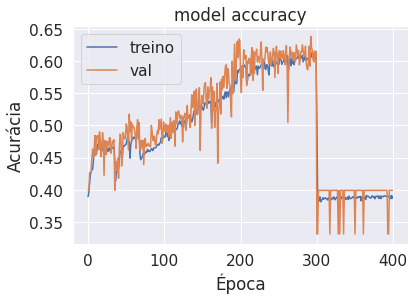

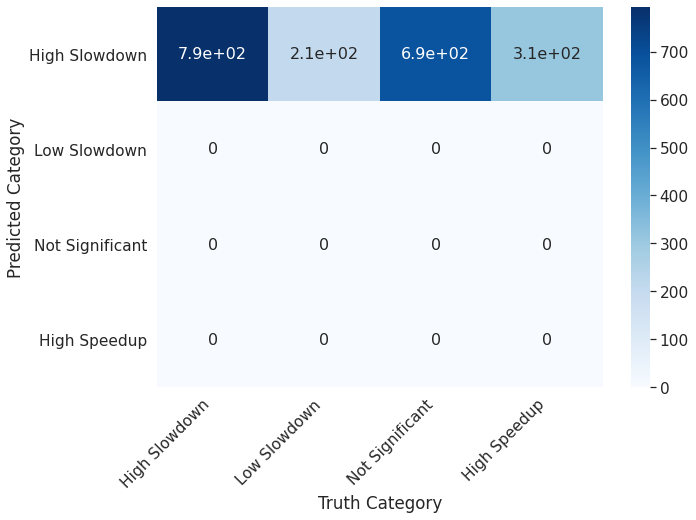

In [13]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_data-call_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-data-call',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graphs with control edges only

Information saved to ./model_data/GNN_cdfg-control_150x150_1616346179.4730325/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 150, 150)]   0                                            
____________________________________________

18828

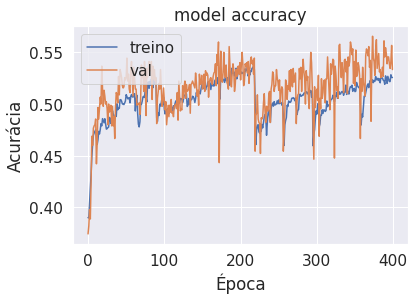

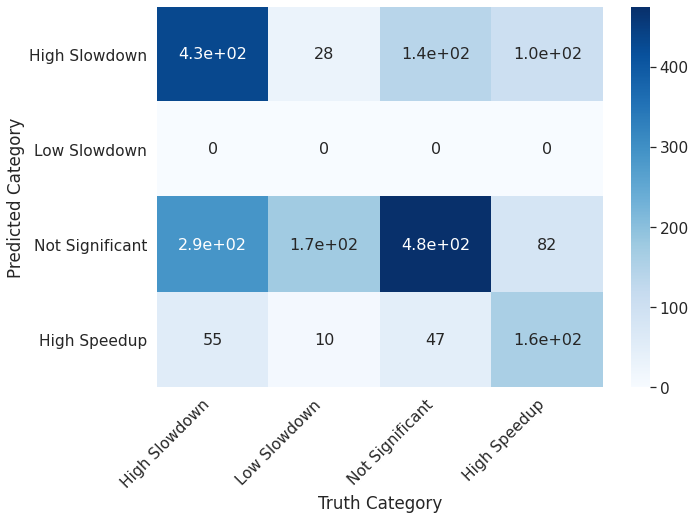

In [14]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graphs with data edges only

Information saved to ./model_data/GNN_cdfg-data_150x150_1616348002.8249388/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_data_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________________________

18275

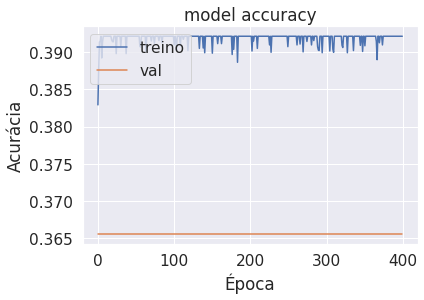

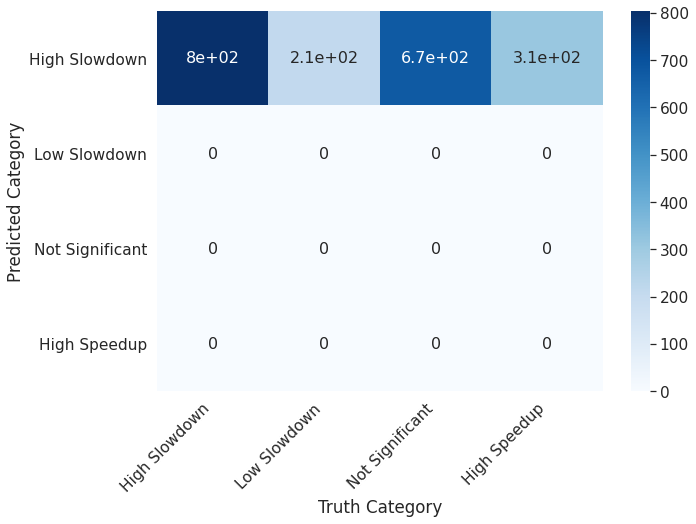

In [15]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_data_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-data',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graphs with call edges only

Information saved to ./model_data/GNN_cdfg-call_150x150_1616349826.075172/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_call_20000samples_150x150.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 150, 150)]   0                                            
___________________________________________________

18824

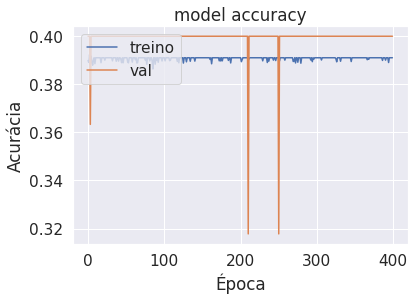

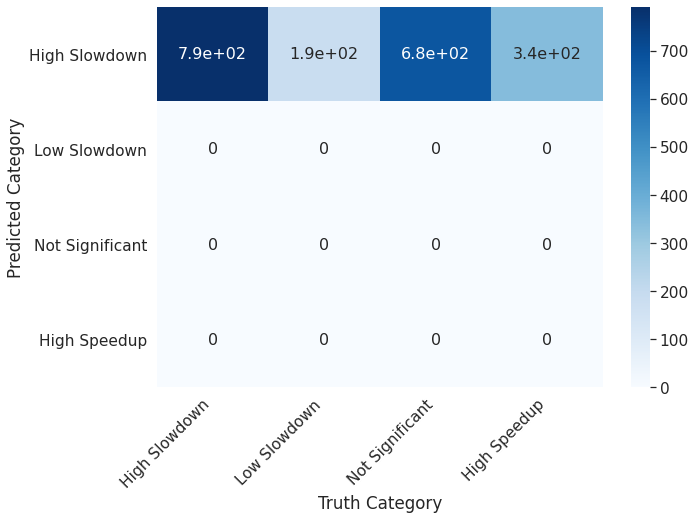

In [16]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_call_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-call',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

# Training with CDFG graphs. Shape 300x300

## Graph with control, data and call edges

Information saved to ./model_data/GNN_cdfg-control-data-call_300x300_1616351685.7149458/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-data-call_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 300, 300)]   0                                            
________________________

18711

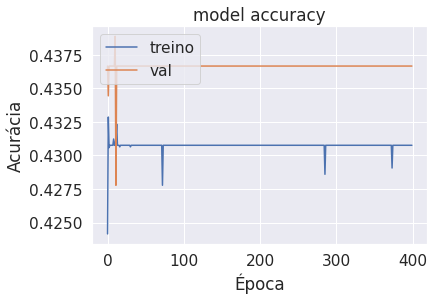

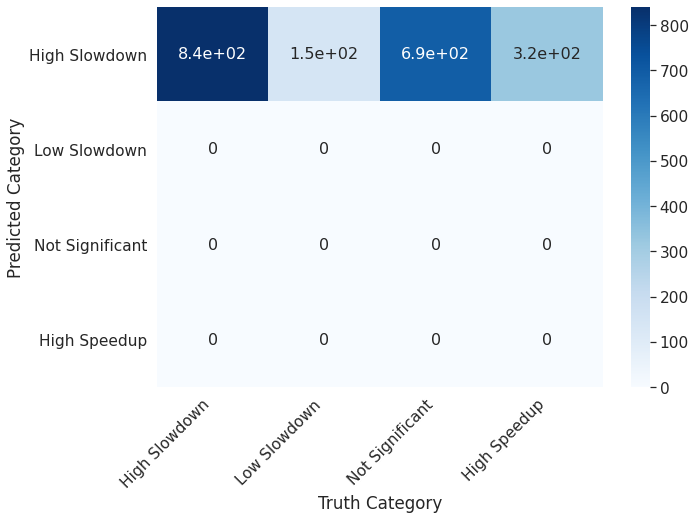

In [17]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-data-call_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-data-call',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with control and data edges

Information saved to ./model_data/GNN_cdfg-control-data_300x300_1616356386.3843572/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-data_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 300, 300)]   0                                            
_________________________________

18834

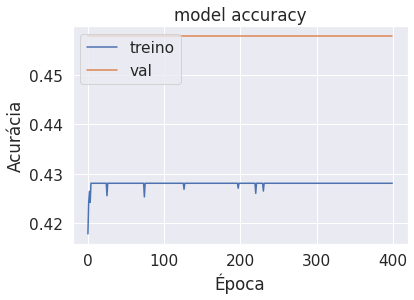

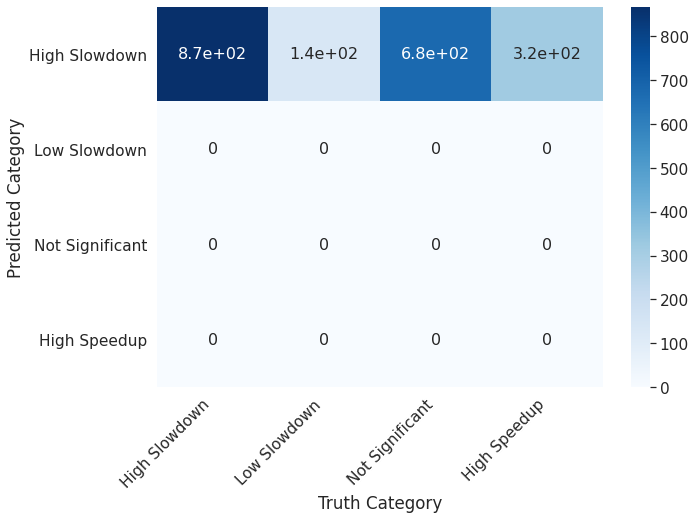

In [18]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-data_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-data',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with control and call edges

Information saved to ./model_data/GNN_cdfg-control-call_300x300_1616361090.0860975/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-call_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, 300, 300)]   0                                            
_________________________________

18712

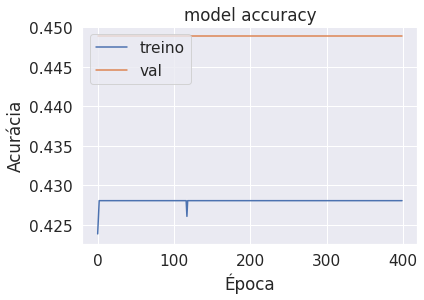

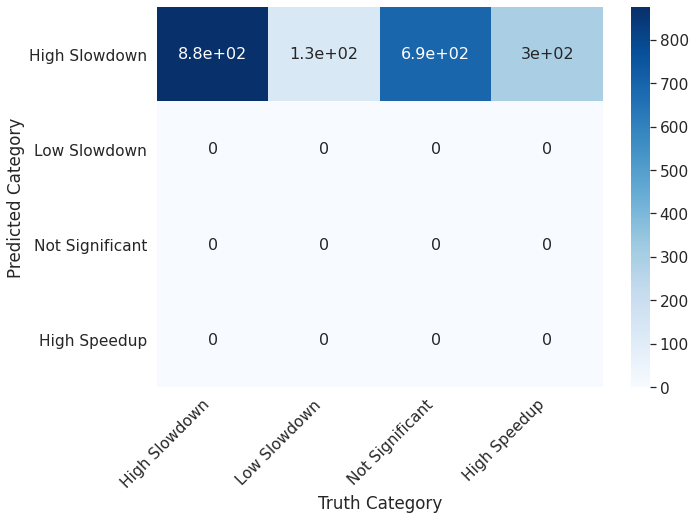

In [19]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-call_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-call',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with data and call edges

Information saved to ./model_data/GNN_cdfg-data-call_300x300_1616365817.2980556/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_data-call_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 300, 300)]   0                                            
_______________________________________

18834

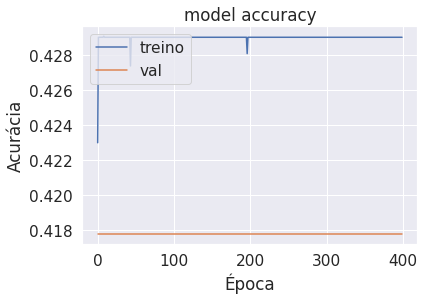

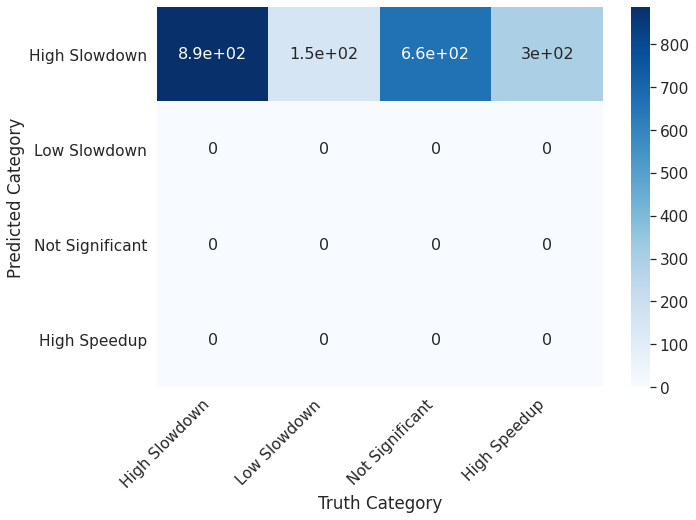

In [20]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_data-call_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-data-call',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with control edges only

Information saved to ./model_data/GNN_cdfg-control_300x300_1616370551.378965/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 300, 300)]   0                                            
____________________________________________

18834

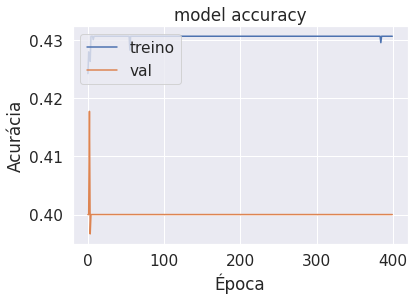

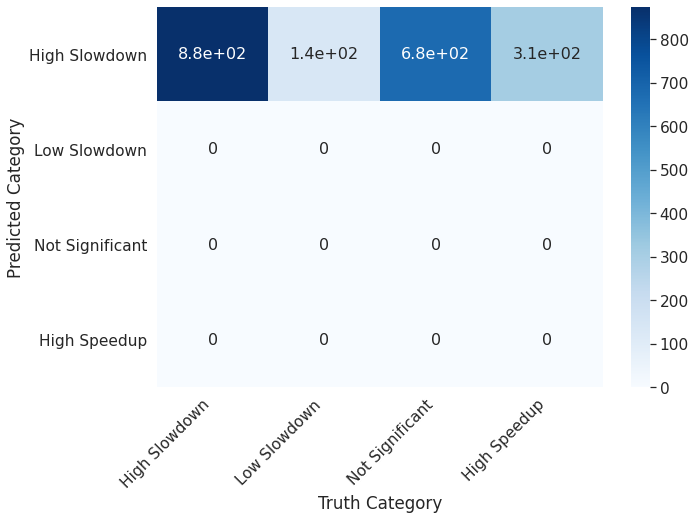

In [21]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with data edges only

Information saved to ./model_data/GNN_cdfg-data_300x300_1616375264.5378492/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_data_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           [(None, 300, 300)]   0                                            
_________________________________________________

18712

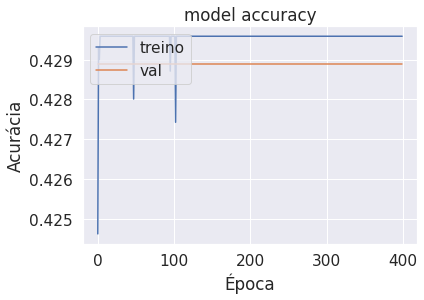

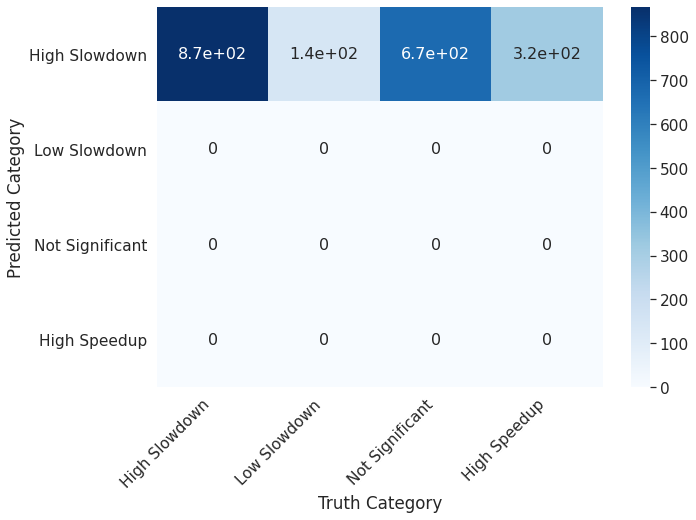

In [22]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_data_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-data',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()

## Graph with call edges only

Information saved to ./model_data/GNN_cdfg-call_300x300_1616379992.011032/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_call_20000samples_300x300.npz
Speedup classes generated from data
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 300, 200)]   0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 300, 300)]   0                                            
__________________________________________________

18773

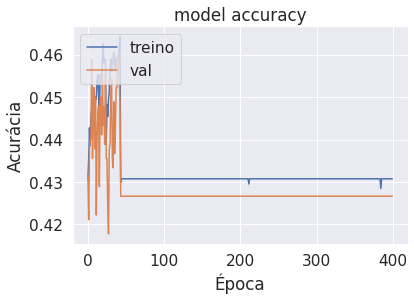

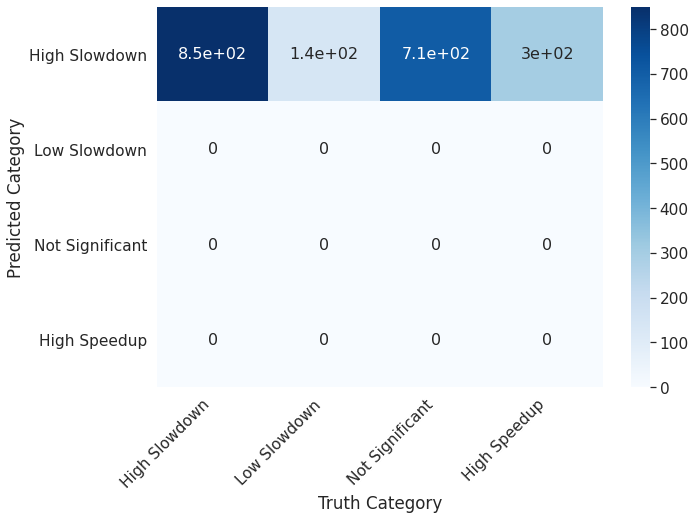

In [23]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_call_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-call',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 200,    # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 32,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'samples': 20000      # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=0.1)
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()
print('Start training')
# Train model
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=0.05, epochs=config['epochs'])
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Save model and weights to files
save_model(data_dir, model)

# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

# Cleanup
gc.collect()